In [49]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import brier_score_loss, roc_auc_score
import pandas as pd

warnings.filterwarnings("ignore")

def last_word(output):
    return output.split()[-1]

assessor_id = "Llama-2-13b-chat-hf"
df = pd.read_csv(f"{assessor_id}_assessor_id_epoch=2.csv")
# df_ood = pd.read_csv("Llama-2-7b-hf_assessor_ood_epoch=1.csv")

df["assessor_output"] = df["assessor_output"].map(last_word)

def prob_top2_to_self_confidence(p1, p2, output):
    answer = output
    # print(answer)  ############ SANITY CHECK
    if answer == "Yes":
        return p1
    else:
        return p2

prob_lis = []
for i in range(len(df)):
    prob = prob_top2_to_self_confidence(df["confidence_top1"].iloc[i], 
                                        df["confidence_top2"].iloc[i], 
                                        df["assessor_output"].iloc[i])

    prob_lis.append(prob) 
    
df["assessor_prob"] = prob_lis

In [28]:
# correlation between column 1 and column2
# print(df_test['nor_prob'].corr(df_test['assessor_prob'], method='spearman'))
roc_auc_score(df['correct'], df['assessor_prob'])
df = df

df['bucket'] = pd.qcut(df["assessor_prob"], q=10)
grouped = df.groupby('bucket').agg({prob:'mean', 'correct':'mean'})
brier_score = brier_score_loss(df['correct'], df[prob])
calibration_loss = ((grouped[prob] - grouped['correct'])**2).mean()
calibration_loss

KeyError: 'Column(s) [0.3305415213108063] do not exist'

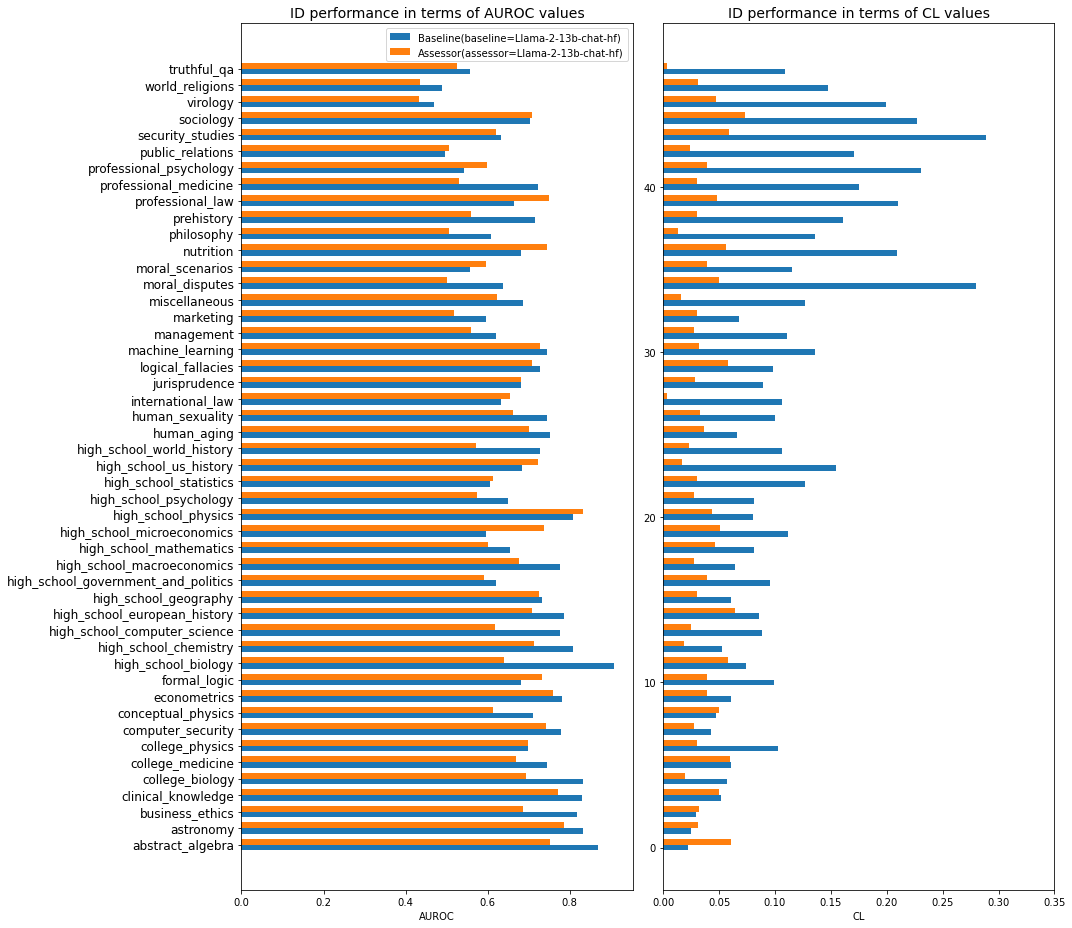

In [51]:

model = "Llama-2-13b-chat-hf"
df_test = df[df["model"]==model]

def plot_metric(df, metric, ax):
    scores = []
    tasks = sorted(df["task"].unique(), key=lambda x: df[df["task"]==x]["correct"].mean(), reverse=True) # from highest to lowest.
    for task in tasks:
        df_subtask = df[df["task"]==task]
        df_subtask["prob"] = df_subtask["nor_prob"]

        if metric == 'BS':
            score_prob = brier_score_loss(df_subtask['correct'], df_subtask['prob'])
            scores.append(('Baseline', task, score_prob))
            score_assessor = brier_score_loss(df_subtask['correct'], df_subtask['assessor_prob'])
            scores.append(('Assessor', task, score_assessor))

        elif metric == 'AUROC':
            score_prob = roc_auc_score(df_subtask['correct'], df_subtask['prob'])
            scores.append(('Baseline', task, score_prob))
            score_assessor = roc_auc_score(df_subtask['correct'], df_subtask['assessor_prob'])
            scores.append(('Assessor', task, score_assessor))

        elif metric == 'CL' or metric == 'RL':
            for method, prob in [('Baseline', 'prob'), ('Assessor', 'assessor_prob')]:
                df_subtask['bucket'] = pd.qcut(df_subtask[prob], q=10)
                grouped = df_subtask.groupby('bucket').agg({prob:'mean', 'correct':'mean'})
                brier_score = brier_score_loss(df_subtask['correct'], df_subtask[prob])
                calibration_loss = ((grouped[prob] - grouped['correct'])**2).mean()
                refinement_loss = brier_score - calibration_loss

                if metric == 'CL':
                    scores.append((method, task, calibration_loss))
                else:
                    scores.append((method, task, refinement_loss))

    df_scores = pd.DataFrame(scores, columns=['Method', 'Task', metric])

    bar_width = 0.35
    index = np.arange(len(df["task"].unique()))

    bar1 = ax.barh(index, df_scores[df_scores['Method'] == 'Baseline'][metric], bar_width, label='Baseline' + f"(baseline={model})")
    bar2 = ax.barh(index + bar_width, df_scores[df_scores['Method'] == 'Assessor'][metric], bar_width, label='Assessor' + f"(assessor={assessor_id})")
    # print(df_scores)
    avg_score_baseline = df_scores[df_scores['Method'] == 'Baseline'][metric].mean()
    avg_score_assessor = df_scores[df_scores['Method'] == 'Assessor'][metric].mean()

    # ax.axvline(avg_score_baseline, color='blue', linestyle='--', label='Macro Average Baseline')
    # ax.axvline(avg_score_assessor, color='orange', linestyle='--', label='Macro Average Assessor')

    
    ax.set_xlabel(metric)
    ax.set_title('ID performance in terms of ' + metric + ' values', fontsize=14)
    if metric == "AUROC":
        # ax.set_ylabel('Task')
        ax.set_yticks(index + bar_width / 2)
        ax.set_yticklabels(df["task"].unique(), fontsize=12)
    if metric == "AUROC":
        ax.legend()
        
    if metric != "AUROC":
        ax.set_xlim(0, 0.35)
        
fig, axs = plt.subplots(1, 2, figsize=(15, 13))

plot_metric(df_test, 'AUROC', axs[0])
plot_metric(df_test, 'CL', axs[1])
# plot_metric(df_test, 'BS', axs[1, 0])
# plot_metric(df_test, 'RL', axs[1, 1])

plt.tight_layout()
plt.savefig('ID_performance_comparison_MC.pdf')  # Save the plot to a PDF
plt.show()

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
import matplotlib.pyplot as plt

# Assuming df_test is already defined
# df_test = pd.read_csv('your_data.csv')
lis = []
for l in range(100):
    
    # Define predictors and target
    X = df_test[['nor_prob', 'assessor_prob']]
    y = df_test['correct']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=l)

    # Initialize the Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=300, max_depth=3, min_samples_split=4, random_state=42)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    # Calculate the AUC-ROC
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Calculate the Brier Score
    brier_score = brier_score_loss(y_test, y_pred_proba)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    lis.append(auc_roc)
    """
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    """
    print(f'AUC-ROC: {auc_roc:.2f}')
    print(f'Brier Score: {brier_score:.2f}')

AUC-ROC: 0.72
Brier Score: 0.21
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.75
Brier Score: 0.20
AUC-ROC: 0.75
Brier Score: 0.20
AUC-ROC: 0.74
Brier Score: 0.21
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.72
Brier Score: 0.21
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.75
Brier Score: 0.20
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.73
Brier Score: 0.20
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.77
Brier Score: 0.19
AUC-ROC: 0.75
Brier Score: 0.20
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.72
Brier Score: 0.21
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.75
Brier Score: 0.20
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.78
Brier Score: 0.19
AUC-ROC: 0.75
Brier Score: 0.20
AUC-ROC: 0.73
Brier Score: 0.21
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC: 0.74
Brier Score: 0.20
AUC-ROC:

In [48]:
sum(lis)/len(lis)

0.738698521944241

In [45]:
# Get feature importances
importances = rf.feature_importances_

# Create a dataframe of feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the dataframe by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importances)

         Feature  Importance
0       nor_prob    0.626673
1  assessor_prob    0.373327


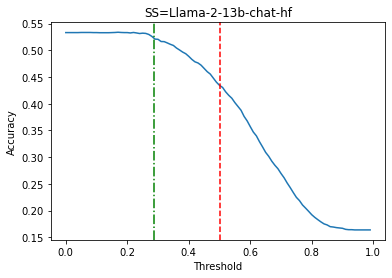

In [53]:
df = pd.read_csv("Llama-2-13b-chat-hf_assessor_id_epoch=2_phase2.csv")

df["correct_phase2"] = (df["output_phase2"].map(lambda x: x[0]) == df["correct_option"]).map({True:"correct", False:"incorrect"})
df["correct"] = df["correct"].map({1:"correct", 0:"incorrect"})
for m in ["llama-2-13b-chat"]:
    aux = df
    ACC = []
    thresh = np.arange(0, 1.0, 0.01)
    for threshold in thresh:
        aux2a = aux[aux["assessor_prob"]<=threshold]
        aux2b = aux[aux["assessor_prob"]>threshold]
        counter_a = aux2a["correct_phase2"].value_counts()
        counter_b = aux2b["correct"].value_counts()
        if "correct" in counter_a and "correct" in counter_b:
            # print((counter_a["correct"] + counter_b["correct"]))
            ACC.append((counter_a["correct"] + counter_b["correct"])/len(aux))
        elif "correct" not in counter_a and "correct" in counter_b:
            ACC.append(counter_b["correct"]/len(aux))
        else:
            ACC.append(counter_a["correct"]/len(aux))

    plt.plot(thresh, ACC)
    plt.axvline(x=0.5, color='r', linestyle='--')  # Add vertical line at x=0.5
    plt.axvline(x=sorted(aux["assessor_prob"])[408], color='g', linestyle='dashdot')  # Add vertical line at x=0.5
    plt.xlabel('Threshold')  # Set x label
    plt.ylabel('Accuracy')  # Set y label
    plt.title(f"SS={aux['model'].iloc[0]}")
    plt.show()